# Library

In [ ]:
!pip install nltk
!pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 287 kB 4.9 MB/s 
     |████████████████████████████████| 106 kB 57.3 MB/s 


In [ ]:
import contractions
import math
import nltk
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import re
import spacy
import string
import unicodedata

from collections import Counter

from copy import deepcopy

from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.utils import effective_n_jobs

from itertools import product

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import plot_confusion_matrix, accuracy_score, classification_report, precision_score, f1_score, recall_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier, plot_tree

import warnings
warnings.filterwarnings("ignore")

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

# Load dataset

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/jfcjaya/dataset/main/suicide_detection_25000.csv", sep = '}', lineterminator = '\n')
columns = ['text', 'class']
df = df[columns]

In [ ]:
df.head()

,text,class
0,Plan B is starting to become more appealingI'v...,suicide
1,LonelinessEvery time I try and talk and talk t...,suicide
2,palim falling apart and my insides are collaps...,suicide
3,Botox?Can you die fom ingesting botox?,suicide
4,So yeah i will do itI will never change how i ...,suicide


In [ ]:
df.shape

(25000, 2)

<Figure size 1440x1080 with 0 Axes>

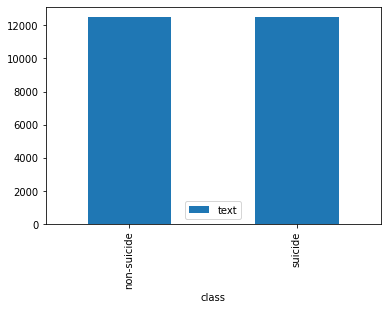

In [ ]:
fig = plt.figure(figsize=(20,15))
df.groupby('class').count().plot.bar()

In [ ]:
df.isnull().sum()

text     0
class    0
dtype: int64

# A. Preprocessing

In [ ]:
# résumé -> resume
def remove_accent(text):
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')

In [ ]:
testing_text = "here is my résumé."
print(remove_accent(testing_text))

here is my resume.


In [ ]:
# i'm -> i am
def remove_contraction(text):
    return contractions.fix(text)

In [ ]:
testing_text = "We're going to go to the mall."
print(remove_contraction(testing_text))

We are going to go to the mall.


In [ ]:
# emojis, dll
def remove_special_char(text):
    return re.sub(r'[^a-zA-z0-9.,!?/:;\"\'\s]' , ' ', text)

In [ ]:
testing_text = "I am so happy! 😭😭😭 $ &"
print(remove_special_char(testing_text))

I am so happy!        


In [ ]:
def remove_url(text):
    return re.sub(r"http\S+", "", text)

In [ ]:
testing_text = "hey, watch this! https://www.youtube.com/watch?v=dQw4w9WgXcQ"
print(remove_url(testing_text))

hey, watch this! 


In [ ]:
# hello    world -> hello world
def remove_redundant_space(text):
    # trailing spaces
    text = re.sub(' +$', '', text)
    # leading spaces
    text = re.sub('^ +', '', text)
    # redundant spaces
    text = re.sub(' +', ' ', text)
    return text

In [ ]:
testing_text = "   leading space         redundant spaces trailing space        "
print(remove_redundant_space(testing_text))

leading space redundant spaces trailing space


In [ ]:
# hello 123 -> hello
def remove_num(text):
    return re.sub(r'\d+', ' ', text)

In [ ]:
testing_text = "Hello 123"
print(remove_num(testing_text))

Hello  


In [ ]:
# hello! -> hello
def remove_punctuation(text):
    text = re.sub('_', ' ', text)
    text = re.sub(r'[^\w\s]', ' ', text)
    return text;

In [ ]:
testing_text = "asdlfkaj!\"lsdjkflkdfj#$%&lsdkjflkdjf'()*+, -lskdfjldkjf./:;<=>?@[\]^_`{|}~"
print(remove_punctuation(testing_text))

asdlfkaj  lsdjkflkdfj    lsdkjflkdjf        lskdfjldkjf                   


In [ ]:
def preprocess_basic(text):
    text = remove_accent(text)
    text = remove_url(text)
    text = remove_contraction(text)
    text = remove_special_char(text)
    text = remove_num(text)
    text = remove_punctuation(text)
    text = text.lower()
    text = remove_redundant_space(text)
    return text

# B. Preprocess - More

### Remove insignificant words

We define insignificant words as the word that has less occurence than a predefined threshold.

In [ ]:
def remove_noise(text: str, 
                 freq: Counter, 
                 threshold: int):
    
    text = " ".join([word for word in text.split()
                     if freq[word] >= threshold])
    return remove_redundant_space(text)

### Change slang to formal

In [ ]:
dict_slang = pd.read_csv("https://raw.githubusercontent.com/jfcjaya/dataset/main/slang.csv")

In [ ]:
columns = ['slang', 'formal']
dict_slang.sort_values('slang', inplace = True)
dict_slang.drop_duplicates(subset = columns, inplace = True)

# Convert into python dict
slang_word = pd.Series(dict_slang['formal'].values, index = dict_slang['slang']).to_dict()

In [ ]:
def slang_to_formal(text):
    return " ".join([slang_word[word] if word in slang_word
                     else word
                     for word in text.split(' ')])

In [ ]:
testing_text = "2 svm sucks"
print(slang_to_formal(testing_text))

today svm sucks


In [ ]:
print(slang_word)

{'2day': 'today', '2m2h': 'too much too handle', '2moro': 'tomorrow', '2nite': 'tonight', '4eae': 'for ever and ever', 'aab': 'average at best', 'aac': 'apple audio compression', 'aaf': 'as a friend', 'aak': 'alive and kicking', 'aamof': 'as a matter of fact', 'aap': 'always a pleasure', 'aarp': 'american association of retired persons', 'aat': 'and another thing at all times', 'aawy': 'and also with you', 'abc': 'american born chinese', 'abdc': 'americas best dance crew', 'abf': 'all but face', 'abfab': 'absolutely fabulous', 'abg': 'asian baby girl', 'abh': 'actual bodily harm', 'abp': 'already been posted', 'abu': 'anyone but  united', 'ac': 'air conditioning alternating current', 'accually': 'actually', 'ack': 'acknowledge', 'aclu': 'american civil liberties union', 'acme': 'a company that makes everything', 'acp': 'automatic colt pistol', 'acta': 'anti counterfeiting trade agreement', 'acu': 'army combat uniform', 'ad': 'anno domini', 'adad': 'another day another dollar', 'add': '

### Stopword Removal

In [ ]:
stopword_list = stopwords.words('english')
whitelist = ["not", "no", "against"]
for word in whitelist:
    stopword_list.remove(word)

def remove_stopwords(text):
    words = word_tokenize(text)
    filter = [word
              for word in words
              if not word in stopword_list]
    return ' '.join(filter)

In [ ]:
print(stopword_list)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'nor', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 

In [ ]:
testing_text = "i am not a burden"
print(remove_stopwords(testing_text))

not burden


### Lemmatization

In [ ]:
try:
    lemma = spacy.load("en_core_web_sm")
except: # If not present, we download
    spacy.cli.download("en_core_web_sm")
    lemma = spacy.load("en_core_web_sm")

def lemmatize_text(text):
    text = lemma(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

In [ ]:
testing_text = "we are going to do homework this evening"
print(lemmatize_text(testing_text))

we be go to do homework this evening


In [ ]:
def preprocess_advanced(text: str,
                        freq: Counter,
                        threshold: int):
    text = remove_noise(text, freq, threshold)
    text = slang_to_formal(text)
    text = remove_stopwords(text)
    text = lemmatize_text(text)
    return text

### Combining All Preprocessing Method

In [ ]:
def count_frequency(data: pd.DataFrame):
        # generate word frequency table
        word_list = []
        for sentence in data['text']:
            for word in sentence.split():
                word_list.append(word)
        
        return Counter(word_list)

In [ ]:
def preprocess(data: pd.DataFrame, threshold: int):
    clean = deepcopy(data)
    counter = count_frequency(clean)
    clean['text'] = clean['text'].apply(preprocess_basic)
    clean['text'] = clean['text'].apply(preprocess_advanced, args =  (counter, threshold))
    return clean

# C. Dataset cleaning

In [ ]:
%time dataset = preprocess(df, 50)

CPU times: user 4min 40s, sys: 1.16 s, total: 4min 41s
Wall time: 4min 44s


In [ ]:
def split(data, ratio):
    x = data['text']
    y = data['class']
    x_train, x_test, y_train, y_test = train_test_split(
                                                x, y, 
                                                test_size = ratio,
                                                random_state = 777, # lucky number
                                                stratify = y
                                            )

    return [x_train, x_test, y_train, y_test]

In [ ]:
train_test_data = split(dataset, 0.2)
x_train, x_test, y_train, y_test = train_test_data

# D. Model

### Create TF-IDF Vectorizer

In [ ]:
tfidf = TfidfVectorizer(max_features = 300, ngram_range = (1, 1))
tfidf.fit(x_train.values)

TfidfVectorizer(max_features=300)

### Create Word2Vec Model

In [ ]:
def get_w2v_model(x_raw):
    x_token = deepcopy(x_raw)
    x_token = [[w for w in line.split() if (w != "" and w != " ")] for line in x_token]

    w2v_model = Word2Vec(
                    x_token, 
                    size = 300, 
                    window = 2, 
                    workers = effective_n_jobs(-1), 
                    sg = 1,
                    seed = 777,
                    iter = 10,
                    min_count = 50 
                )
    return w2v_model

In [ ]:
w2v = get_w2v_model(x_train)

In [ ]:
print("vocab size: ", len(w2v.wv.vocab))
print(w2v.wv.vocab)

vocab size:  1054
{'first': <gensim.models.keyedvectors.Vocab object at 0x7f52ffaef410>, 'one': <gensim.models.keyedvectors.Vocab object at 0x7f52f6549bd0>, 'time': <gensim.models.keyedvectors.Vocab object at 0x7f52f6549c10>, 'guess': <gensim.models.keyedvectors.Vocab object at 0x7f52f6549c50>, 'miss': <gensim.models.keyedvectors.Vocab object at 0x7f52f6549cd0>, 'favourite': <gensim.models.keyedvectors.Vocab object at 0x7f52f6549d50>, 'get': <gensim.models.keyedvectors.Vocab object at 0x7f52f6549d90>, 'free': <gensim.models.keyedvectors.Vocab object at 0x7f52f6549dd0>, 'award': <gensim.models.keyedvectors.Vocab object at 0x7f52f6549c90>, 'filler': <gensim.models.keyedvectors.Vocab object at 0x7f52f6549d10>, 'mean': <gensim.models.keyedvectors.Vocab object at 0x7f52f6549e10>, 'people': <gensim.models.keyedvectors.Vocab object at 0x7f52f6549e50>, 'attractive': <gensim.models.keyedvectors.Vocab object at 0x7f52f6549e90>, 'dumb': <gensim.models.keyedvectors.Vocab object at 0x7f52f6549ed0>,

In [ ]:
def get_w2v_arr(x_token):
        res = np.zeros((len(x_token), 300))
        for i in range(len(x_token)):
            for word in x_token[i]:
                try:
                    res[i] += w2v[word]
                except KeyError:
                    continue

        res = MinMaxScaler(feature_range = (-1, 1)).fit_transform(res)
        return res

In [ ]:
class SKLearn_Model:
    def __init__(self, 
                 feature: str, 
                 model_type: str,
                 grid_search: bool, 
                 **kwargs):
        
        # initialize parameter
        self.feature = feature
        self.model_type = model_type
        self.grid_search = grid_search
        self.kwargs = kwargs

        # get dataset and feature extraction
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_data
        self._create_feature()

        # create model
        self._train_model()
    
    def _create_feature(self):
        if self.feature == "tf-idf":
            self.x_train = tfidf.transform(self.x_train.values)
            self.x_test = tfidf.transform(self.x_test.values)
            self.transformer = tfidf

        elif self.feature == "w2v":
            x_train_tok = [[w for w in line.split() if (w != "" and w != " ")] for line in self.x_train]
            x_test_tok  = [[w for w in line.split() if (w != "" and w != " ")] for line in self.x_test]

            self.x_train = get_w2v_arr(x_train_tok)
            self.x_test = get_w2v_arr(x_test_tok)

    def _train_model(self):
        if self.grid_search:
            self.model_param = self.kwargs['grid_param']
            
        if self.model_type == "mnb":
            if(self.feature == "w2v"): # rescale as naive bayes only accepts non-negative values
                self.x_train = MinMaxScaler(feature_range = (0, 1)).fit_transform(self.x_train)
                self.x_test = MinMaxScaler(feature_range = (0, 1)).fit_transform(self.x_test)
            baseline = MultinomialNB()

        elif self.model_type == "svm":
            baseline = LinearSVC()

        elif self.model_type == "dt":
            baseline = DecisionTreeClassifier()

        if self.grid_search:
            model_grid = GridSearchCV(baseline, param_grid = self.model_param, scoring = "accuracy", verbose = 2, n_jobs = -1)
            %time model_grid.fit(self.x_train, self.y_train)
            self.best_params = model_grid.best_params_
            self.model = model_grid.best_estimator_
        else:
            self.model = baseline
        
        self.model.fit(self.x_train, self.y_train)

    def evaluate_model(self):
        print("\nBest Parameter")
        print("=====================================================")
        if self.grid_search:
            print(self.best_params)
        
        y_pred = self.model.predict(self.x_train)
        print("\nTraining Dataset")
        print("=====================================================")
        print(f"accuracy score  : {accuracy_score(self.y_train, y_pred) * 100}")
        print(f"precision score : {precision_score(self.y_train, y_pred, average = 'macro') * 100}")
        print(f"recall score    : {recall_score(self.y_train, y_pred, average = 'macro') * 100}")
        print(f"f1-score        : {f1_score(self.y_train, y_pred, average = 'macro') * 100}")

        y_pred = self.model.predict(self.x_test)
        print("\nTesting Dataset")
        print("=====================================================")
        plot_confusion_matrix(self.model, self.x_test, self.y_test)
        print(f"accuracy score  : {accuracy_score(self.y_test, y_pred) * 100}")
        print(f"precision score : {precision_score(self.y_test, y_pred, average = 'macro') * 100}")
        print(f"recall score    : {recall_score(self.y_test, y_pred, average = 'macro') * 100}")
        print(f"f1-score        : {f1_score(self.y_test, y_pred, average = 'macro') * 100}")
        print("\n")

    def predict(self, text):
        if self.feature == "tf-idf":
            text = self.transformer.transform([text])
        else:
            text = text.split()
            text = self._get_w2v_arr([text], **self.w2v_param)

        prediction = self.model.predict(text)[0]
        return prediction


# E. Evaluation

### Support Vector Machine + TF-IDF

CPU times: user 912 ms, sys: 9.97 ms, total: 922 ms
Wall time: 922 ms

Best Parameter

Training Dataset
accuracy score  : 89.345
precision score : 89.38609111499936
recall score    : 89.345
f1-score        : 89.34222021123104

Testing Dataset
accuracy score  : 88.78
precision score : 88.80016988031059
recall score    : 88.77999999999999
f1-score        : 88.77854165927404




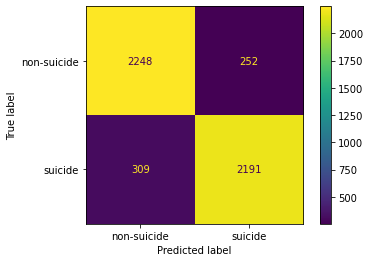

In [ ]:
%time svm_tfidf_base = SKLearn_Model('tf-idf', 'svm', grid_search = False)
svm_tfidf_base.evaluate_model()

Fitting 5 folds for each of 5 candidates, totalling 25 fits
CPU times: user 1.36 s, sys: 26.4 ms, total: 1.39 s
Wall time: 17.2 s
CPU times: user 3.13 s, sys: 31.2 ms, total: 3.16 s
Wall time: 18.9 s

Best Parameter
{'C': 10}

Training Dataset
accuracy score  : 89.385
precision score : 89.42167201038767
recall score    : 89.385
f1-score        : 89.38253077481332

Testing Dataset
accuracy score  : 88.8
precision score : 88.82236168032787
recall score    : 88.8
f1-score        : 88.79838696772336




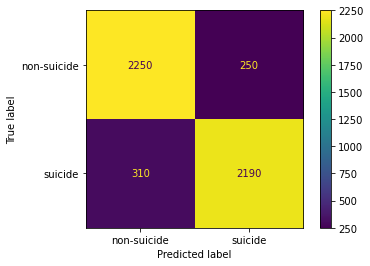

In [ ]:
param = {
    'C': [0.01, 0.1, 1, 10, 100]
}

%time svm_tfidf_grid = SKLearn_Model('tf-idf', 'svm', grid_search = True, grid_param = param)
svm_tfidf_grid.evaluate_model()

### Support Vector Machine + Word2Vec

CPU times: user 31.5 s, sys: 400 ms, total: 31.9 s
Wall time: 31.5 s

Best Parameter

Training Dataset
accuracy score  : 89.02
precision score : 89.32035878386382
recall score    : 89.02
f1-score        : 88.99899148404717

Testing Dataset
accuracy score  : 86.82
precision score : 87.79232703677447
recall score    : 86.82000000000001
f1-score        : 86.73467691128043




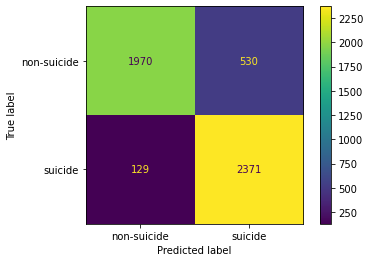

In [ ]:
%time svm_w2v_base = SKLearn_Model('w2v', 'svm', grid_search = False)
svm_w2v_base.evaluate_model()

Fitting 5 folds for each of 5 candidates, totalling 25 fits
CPU times: user 25.8 s, sys: 261 ms, total: 26 s
Wall time: 4min 46s
CPU times: user 57.8 s, sys: 601 ms, total: 58.4 s
Wall time: 5min 18s

Best Parameter
{'C': 1}

Training Dataset
accuracy score  : 89.075
precision score : 89.35067865595323
recall score    : 89.07499999999999
f1-score        : 89.055832138163

Testing Dataset
accuracy score  : 86.72
precision score : 87.7146778624208
recall score    : 86.72
f1-score        : 86.6318579575315




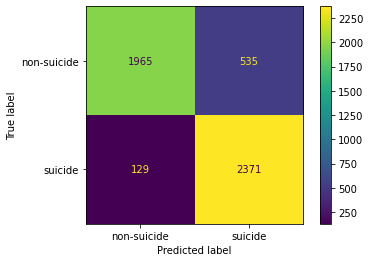

In [ ]:
param = {
    'C': [0.01, 0.1, 1, 10, 100]
}

%time svm_w2v_grid = SKLearn_Model('w2v', 'svm', grid_search = True, grid_param = param)
svm_w2v_grid.evaluate_model()

### Multinomial Naive Bayes + TF-IDF

CPU times: user 820 ms, sys: 2.98 ms, total: 823 ms
Wall time: 824 ms

Best Parameter

Training Dataset
accuracy score  : 82.935
precision score : 83.31860678228036
recall score    : 82.935
f1-score        : 82.88573963933304

Testing Dataset
accuracy score  : 83.28
precision score : 83.72760033312491
recall score    : 83.28
f1-score        : 83.22434239422185




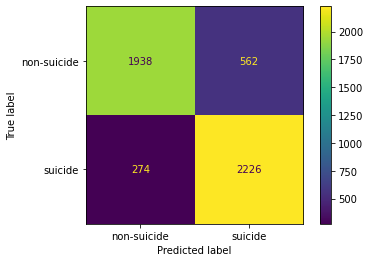

In [ ]:
%time mnb_base = SKLearn_Model('tf-idf', 'mnb', grid_search = False)
mnb_base.evaluate_model()

Fitting 5 folds for each of 8 candidates, totalling 40 fits
CPU times: user 327 ms, sys: 21 ms, total: 348 ms
Wall time: 2.66 s
CPU times: user 1.15 s, sys: 24 ms, total: 1.17 s
Wall time: 3.5 s

Best Parameter
{'alpha': 0.0001, 'fit_prior': True}

Training Dataset
accuracy score  : 82.935
precision score : 83.3273377518492
recall score    : 82.935
f1-score        : 82.88462839164589

Testing Dataset
accuracy score  : 83.2
precision score : 83.65283251431259
recall score    : 83.2
f1-score        : 83.14329404115443




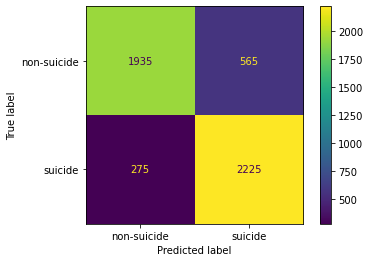

In [ ]:
param = {
    'alpha': [0.0001, 0.001, 0.01, 1.0],
    'fit_prior': [True, False],
}

%time mnb_grid = SKLearn_Model('tf-idf', 'mnb', grid_search = True, grid_param = param)
mnb_grid.evaluate_model()

### Multinomial Naive Bayes + Word2Vec

CPU times: user 8.75 s, sys: 348 ms, total: 9.1 s
Wall time: 8.78 s

Best Parameter

Training Dataset
accuracy score  : 72.225
precision score : 73.32858801687321
recall score    : 72.22500000000001
f1-score        : 71.89258591055784

Testing Dataset
accuracy score  : 73.56
precision score : 73.94252882534133
recall score    : 73.56
f1-score        : 73.45396878026087




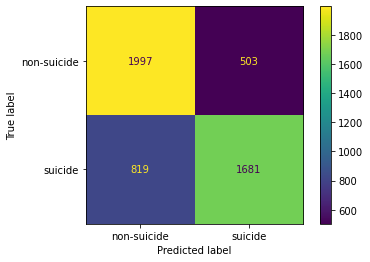

In [ ]:
%time mnb_tfidf_base = SKLearn_Model('w2v', 'mnb', grid_search = False)
mnb_tfidf_base.evaluate_model()

Fitting 5 folds for each of 8 candidates, totalling 40 fits
CPU times: user 352 ms, sys: 40.1 ms, total: 392 ms
Wall time: 3.31 s
CPU times: user 8.61 s, sys: 408 ms, total: 9.01 s
Wall time: 11.6 s

Best Parameter
{'alpha': 1.0, 'fit_prior': True}

Training Dataset
accuracy score  : 72.225
precision score : 73.32858801687321
recall score    : 72.22500000000001
f1-score        : 71.89258591055784

Testing Dataset
accuracy score  : 73.56
precision score : 73.94252882534133
recall score    : 73.56
f1-score        : 73.45396878026087




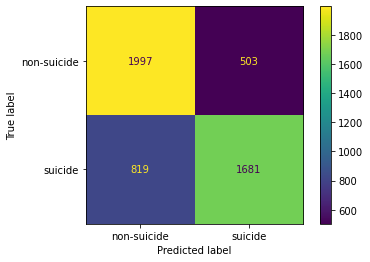

In [ ]:
param = {
    'alpha': [0.0001, 0.001, 0.01, 1.0],
    'fit_prior': [True, False],
}

%time mnb_tfidf_grid = SKLearn_Model('w2v', 'mnb', grid_search = True, grid_param = param)
mnb_tfidf_grid.evaluate_model()

### Decision Tree + TF-IDF

In [ ]:
def get_decision_tree(classifier):
    fig = plt.figure(figsize=(15,10))
    _ = plot_tree(classifier.model,
                  class_names=['suicide', "non-suicide"],
                  filled = True)

CPU times: user 6.07 s, sys: 10.7 ms, total: 6.08 s
Wall time: 6.07 s

Best Parameter

Training Dataset
accuracy score  : 99.74
precision score : 99.74134500596897
recall score    : 99.74000000000001
f1-score        : 99.73999824238811

Testing Dataset
accuracy score  : 79.56
precision score : 79.56756929774022
recall score    : 79.56
f1-score        : 79.5586917562724




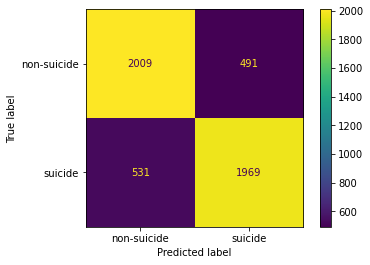

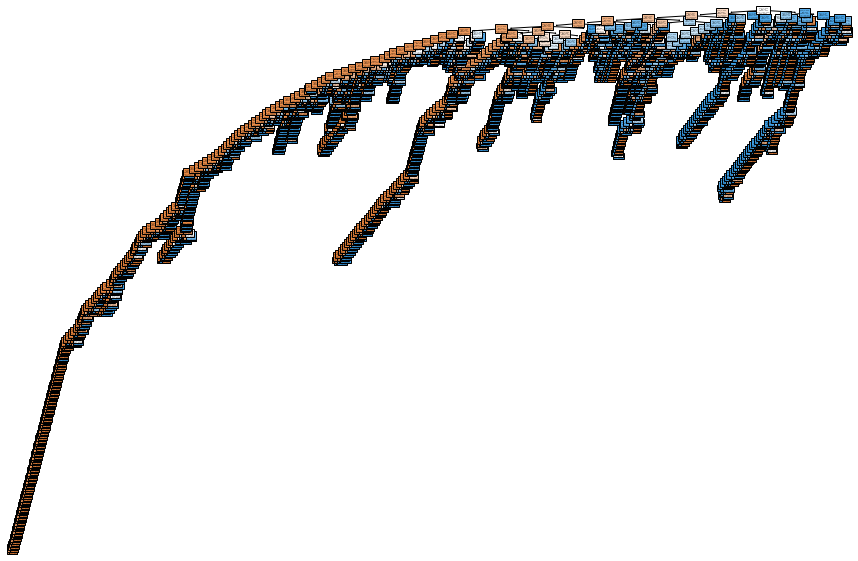

In [ ]:
%time dt_tfidf_base = SKLearn_Model('tf-idf', 'dt', grid_search = False)
dt_tfidf_base.evaluate_model()

get_decision_tree(dt_tfidf_base)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
CPU times: user 4.66 s, sys: 135 ms, total: 4.79 s
Wall time: 2min 9s
CPU times: user 7.6 s, sys: 142 ms, total: 7.75 s
Wall time: 2min 12s

Best Parameter
{'max_depth': 20, 'min_samples_leaf': 1}

Training Dataset
accuracy score  : 92.41
precision score : 92.63596378631325
recall score    : 92.41
f1-score        : 92.39993021153307

Testing Dataset
accuracy score  : 81.76
precision score : 81.96871221330426
recall score    : 81.76
f1-score        : 81.7301807317832




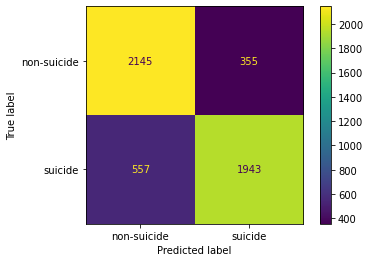

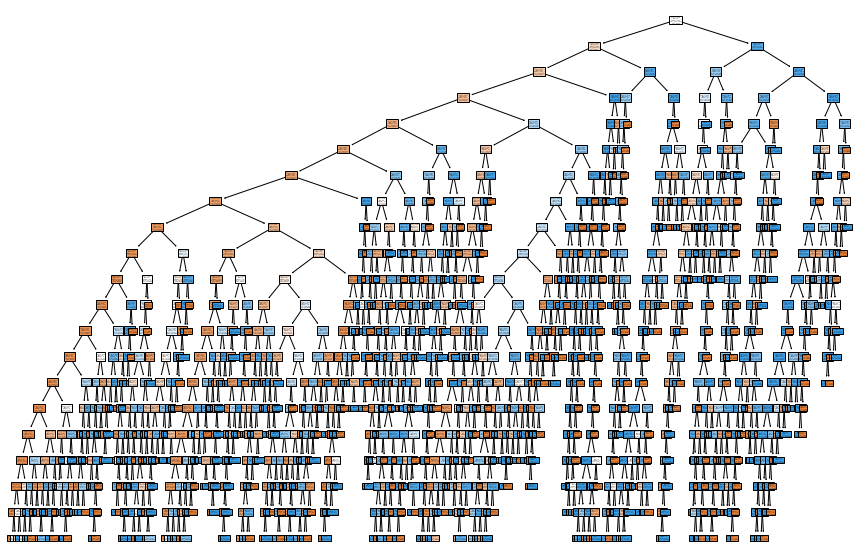

In [ ]:
param = {
    'max_depth': [5, 10, 20, 30, 40, 50],
    'min_samples_leaf': [1, 2, 5, 10]
}

%time dt_tfidf_grid = SKLearn_Model('tf-idf', 'dt', grid_search = True, grid_param = param)
dt_tfidf_grid.evaluate_model()

get_decision_tree(dt_tfidf_grid)

### Decision Tree + Word2Vec

CPU times: user 24.2 s, sys: 291 ms, total: 24.5 s
Wall time: 24.2 s

Best Parameter

Training Dataset
accuracy score  : 99.91
precision score : 99.91012776992709
recall score    : 99.91
f1-score        : 99.90999994239996

Testing Dataset
accuracy score  : 31.119999999999997
precision score : 30.339873602048385
recall score    : 31.120000000000005
f1-score        : 30.42985301064205




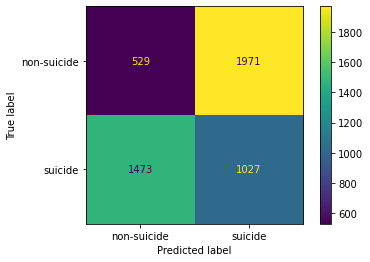

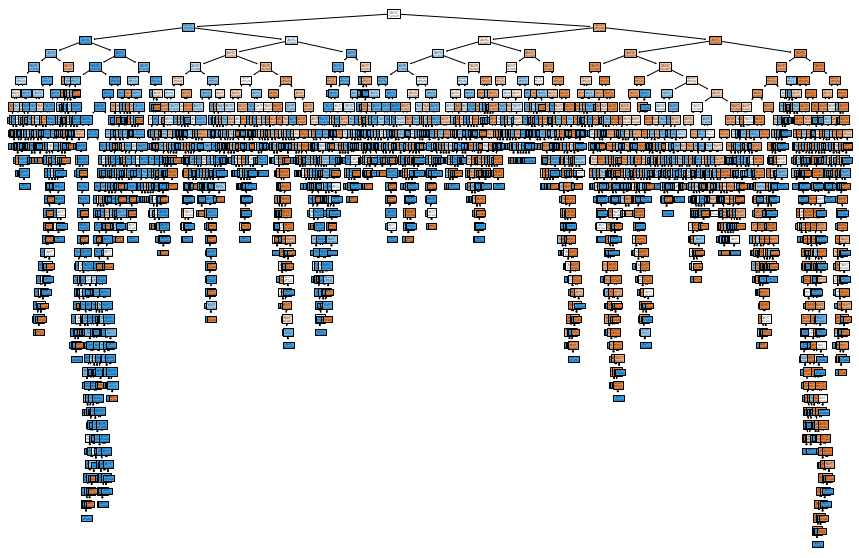

In [ ]:
%time dt_w2v_base = SKLearn_Model('w2v', 'dt', grid_search = False)
dt_w2v_base.evaluate_model()

get_decision_tree(dt_w2v_base)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
CPU times: user 10.1 s, sys: 529 ms, total: 10.6 s
Wall time: 11min 51s
CPU times: user 22.7 s, sys: 803 ms, total: 23.5 s
Wall time: 12min 3s

Best Parameter
{'max_depth': 5, 'min_samples_leaf': 1}

Training Dataset
accuracy score  : 82.66
precision score : 82.87569745097585
recall score    : 82.66
f1-score        : 82.63151133646964

Testing Dataset
accuracy score  : 62.88
precision score : 74.05581666658698
recall score    : 62.88
f1-score        : 58.002178093936095




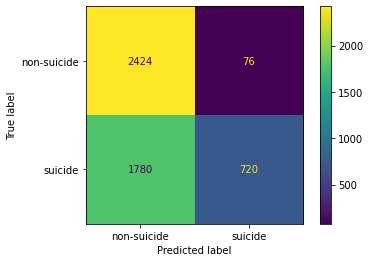

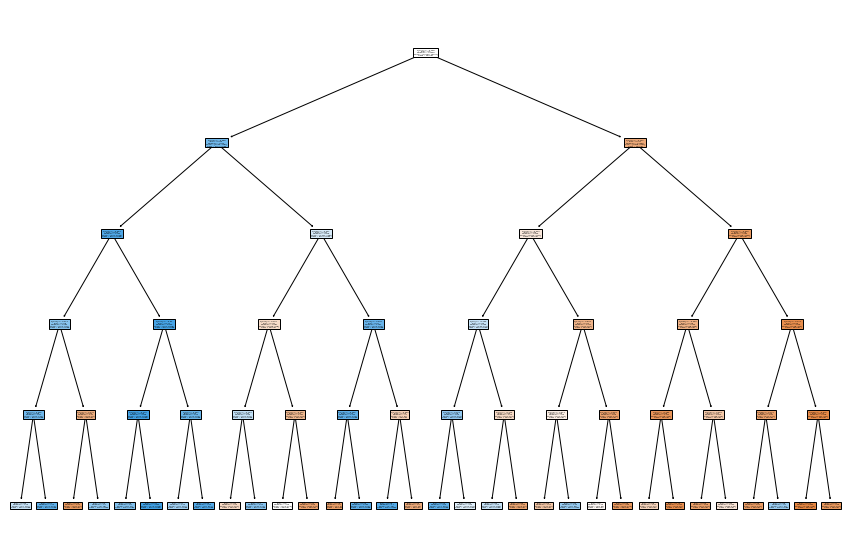

In [ ]:
param = {
    'max_depth': [5, 10, 20, 30, 40, 50],
    'min_samples_leaf': [1, 2, 5, 10]
}

%time dt_w2v_grid = SKLearn_Model('w2v', 'dt', grid_search = True, grid_param = param)
dt_w2v_grid.evaluate_model()

get_decision_tree(dt_w2v_grid)

# F. Import Best Model

In [ ]:
final = deepcopy(svm_tfidf_grid)

In [ ]:
import pickle
pickle.dump(final.model, open('svm_tfidf.sav', 'wb'))
pickle.dump(final.transformer, open('tfidf_transfomer.pkl', 'wb'))